## Парсинг

In [81]:
with open('en_ewt-ud-dev.conllu', 'r', encoding='utf-8') as f:
    conllufile = f.read()

достаем отдельные предложения и информацию о них

In [82]:
import re

In [83]:
sentences = re.findall(r'([\s\S]*?)\n\n', conllufile)

Вместо строки из признаков делаем список из признаков:

In [84]:
def feats_extract(features):
    if features != '_':
        features = features.split('|')
        return features
    else:
        return list(features)

Функция, которая парсит conllu и записывает информацию о токенах в словарь. Вовращает список из предложения и словаря из его слов

In [97]:
def sentence_parts(sentence):
    tokens_dict = {}
    regex = r"^(.*?)\t(.*?)\t(.*?)\t(.*?)\t(.*?)\t(.*?)\t(.*?)\t(.*?)\t(.*?)\t(.*?)$"
    tokens = re.finditer(regex, sentence, re.MULTILINE)
    tokenized_sentence = []
    for token in tokens:
        token_info = {}
        token_info['FORM'] = token.group(2)
        if len(token.group(1).split('-')) == 1:
            tokenized_sentence.append(token_info['FORM'])
        token_info['LEMMA'] = token.group(3)
        token_info['UPOSTAG'] = token.group(4)
        token_info['XPOSTAG'] = token.group(5)
        feats = token.group(6)
        feats = feats_extract(feats)
        token_info['FEATS'] = feats
        token_info['HEAD'] = token.group(7)
        token_info['DEPREL'] = token.group(8)
        token_info['DEPS'] = token.group(9)
        token_info['MISC'] = token.group(10)
        tokens_dict[token.group(1)] = token_info
    full_sentence = ' '.join(tokenized_sentence)
    return [full_sentence, tokens_dict]

## Tense

In [98]:
from collections import defaultdict

Словарь вида 
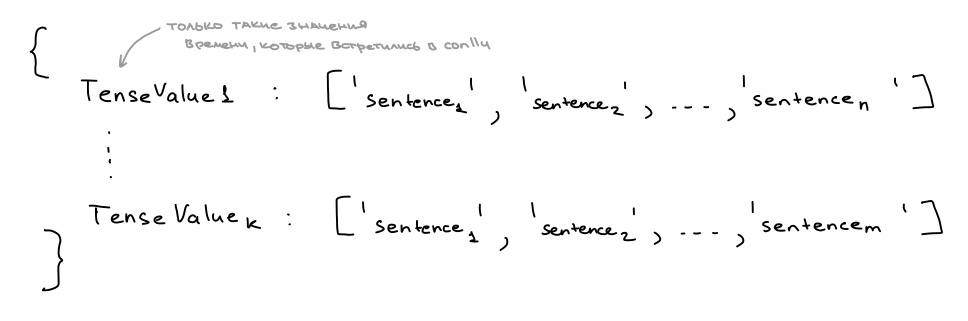

In [99]:
tense_classified_sent = defaultdict(list)

Находим вершину предложения (так как я определяю время преждложения по ворме глагола в вершине предложения)  
И достаем значение времени.

*Я в какой-то момент поняла, что первый мой способ (часть функции до второго цикла) неправильно определял время для пассивов (то есть всегда определял как past, потому что вершинной всегда был смысловой глагол в past participle) и вообще пропускал все предложения, где был предикат с глаголом-связкой (e.g. be kind). Я вроде как исправила, добавив второй цикл, который проверяет, нет ли какого-нибудь другого вспомогательного глагола, который играет функцию связки или вспомогательного глагола при пассиве (при этом пропускаем вспомогательные глаголы в сложных временах. Но теперь это выглядит как-то сложно и слишком настроенным под английский язык... короче, надо думать, такое решение для глобальных целей этой курсовой кажется не подойдет...*

In [100]:
def find_head_predicate(tokens_dict):
    head = 0
    for token in tokens_dict:
        if tokens_dict[token]['HEAD'] == '0':
            head = token
    for token in tokens_dict:
        if (
                (tokens_dict[token]['HEAD'] == head) and 
                ((tokens_dict[token]['DEPREL'] == 'aux:pass') or tokens_dict[token]['DEPREL'] == 'cop')
            ):
            head = token
            break
    if int(head) > 0:
        return head

In [101]:
def tense_value(token_info):
    for feat in token_info['FEATS']:
        if feat.startswith('Tense='):
            return feat.split('=')[1]

Заполняем наш словарь предложениями

In [102]:
for sentence in sentences:
    s_info = sentence_parts(sentence)
    s_tense = tense_value(s_info[1][find_head_predicate(s_info[1])])
    if s_tense:
        if s_info[0] not in tense_classified_sent[s_tense]:
            tense_classified_sent[s_tense].append(s_info[0])

Делит все предложения в пропорции 80/10/10 на этапы tr/va/te, причем внутри каждого этапа количество примеров с каждым значением признака одинаково  
  

Записывает информацию в виде:  
partition&emsp;feature_value&emsp;tokenized_sentence


In [103]:
def writer(feature_name, classified_sentences):
    with open(feature_name + '.txt', 'w', encoding='utf-8') as newf:
        minority_value = min(classified_sentences, key=lambda i: len(classified_sentences[i]))
        size = len(classified_sentences[minority_value])
        tr_size = int(size * 0.8)
        va_size = te_size = int((size - tr_size) / 2)
        partition = {}
        partition['tr'] = tr_size
        partition['va'] = va_size
        partition['te'] = te_size
        start = 0
        end = 0
        for part in partition:
            start = end
            end = start + partition[part]
            values = list(classified_sentences.keys())
            for value in values:
                towrite = ''
                for i in range(start, end):
                    towrite += part + '\t' + value + '\t' + classified_sentences[value][i] + '\n'
                newf.write(towrite)

In [104]:
writer('tense', tense_classified_sent)